# Simulated Nanoscopy images and signal localization algorithm


In [38]:
import numpy as np
import pandas as pd

import pylab as plt

from scipy import ndimage
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

from skimage import filters, exposure
from skimage import measure as m
from skimage.draw import polygon

from tqdm.notebook import tqdm
from copy import deepcopy

%matplotlib notebook

# Simulate image data

1. Generate ground truth images
    - Randomly pick 'n' locations (between 0-100) in a 100x100 image
    - Randomly pick 'n' amplitudes (between 1-10) per location
    - Create image with point-like sources


2. Apply PSF function (simple gaussian)

3. TODO: Add noise: Uniform or Gaussian. 
    - TODO: define SBR as input parameter and set noise params accordingly
    
    

## Some definitions

In [32]:
def simulate_image(img_dim=(100,100), num_of_sites_range=(10,101), amp_min_max=(1,10)):

    # Create a 2D array of zeros with shape (100, 100)
    img = np.zeros(img_dim)

    # Generate random indices for adding ones
    #how many? choose a random no. between 10 to 100
    num_of_sites = np.random.choice(np.arange(*num_of_sites_range), size=1, replace=False)  # Number of ones to add

    # create flattened indices of total length 100*100
    #and pick random indices
    indices = np.random.choice(range(100 * 100), size=num_of_sites, replace=False)

    #no. of photos. Create random amplitudes for each site, in the range 1-10
    amp_min, amp_max = amp_min_max
    aplitudes = np.random.choice(np.arange(amp_min, amp_max), size=num_of_sites, replace=True)

    # Convert flat random-indices to 2D coordinates
    row_indices, col_indices = np.unravel_index(indices, (100, 100))

    # Add ones at random locations
    img[row_indices, col_indices] = aplitudes
    
    #ground truth DF
    df = pd.DataFrame(list(zip(row_indices, col_indices, aplitudes)), columns=["row", "col", "amp"])
    return df, img

def apply_psf(input_img, sigma=1.3):
    # Define the standard deviation of the Gaussian kernel

    # Apply the PSF / Gaussian filter
    convolved_img = ndimage.gaussian_filter(input_img, sigma=sigma)
    return convolved_img

# Define the Sobel operator kernels for gradient calculation
def get_sobel_grad(input_img):
    gradient_x = ndimage.sobel(input_img, axis=0)  # horizontal gradient
    gradient_y = ndimage.sobel(input_img, axis=1)  # vertical gradient

    # Calculate the magnitude of the gradient as a measure of intensity
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return gradient_magnitude

def adaptive_q_perc_thresholding(input_image, block_size=9, use_lcoal_max=True, q_percentile=0.98, local_sbr=2):
    #====== qth percentile or MAX value thresholding ======
    # Create an empty 100x100 image to store the summed results
    output_image = np.zeros_like(convolved_img)

    # Iterate through the rows
    for i in range(convolved_img.shape[0] - block_size + 1):
        # Iterate through the columns
        for j in range(convolved_img.shape[1] - block_size + 1):
            # Extract the current 9x9 block
            block = convolved_img[i:i+block_size, j:j+block_size]

            # Find the threshold value for the top qth percentile in the block
            if use_lcoal_max:
                block_thr = np.max(block)
            else:
                block_thr = np.quantile(block, q_percentile)
            #
            block_mean = np.mean(block)
            block_std = np.std(block)

            # Find the positions of values in the block that are in the top 5%
            high_val_pixels = np.argwhere(block >= block_thr)

            # Update the corresponding positions in the output image and visited_counts with 1
            for k in np.arange(high_val_pixels.shape[0]):
                p,q = high_val_pixels[k, :]
                if block[p,q] > (block_mean + local_sbr*block_std):
                    output_image[i + p, j + q] += block[p,q]
        
    return output_image

def get_contours_in_image(input_image, thr_level=1):
    contours = m.find_contours(input_image, level=thr_level)
    return contours

def get_coo_of_maxima_inside_contour(input_image, input_contour):
    # Create an empty mask image with zeros
    mask = np.zeros_like(convolved_img, dtype=bool)

    contour = np.round(input_contour).astype(int)
    # Generate a list of row and column indices inside the contour region
    rr, cc = polygon(np.round(contour[:, 0]), np.round(contour[:, 1]), mask.shape)

    # Fill the interior of the contour with True
    mask[rr, cc] = True

    # Extract the region inside the contour using the mask
    region_inside_contour = np.where(mask, convolved_img, np.nan)

    # Find the coordinates of the maximum point within the region inside the contour
    max_index = np.nanargmax(region_inside_contour)
    max_point = np.unravel_index(max_index, region_inside_contour.shape)
    return max_point


## Simulate image and apply PSF

* Assuming a gaussian shape of the PSF

In [66]:
# Example image
df, img = simulate_image()
no_of_peaks = df.shape[0]
convolved_img = apply_psf(img, sigma=1.3)

print("No_of_peaks:", no_of_peaks)
df.head(5)

No_of_peaks: 62


,row,col,amp
0,75,53,4
1,74,43,9
2,20,61,6
3,67,96,4
4,68,30,1


# Detect/Localize signal (without noise)

<IPython.core.display.Javascript object>


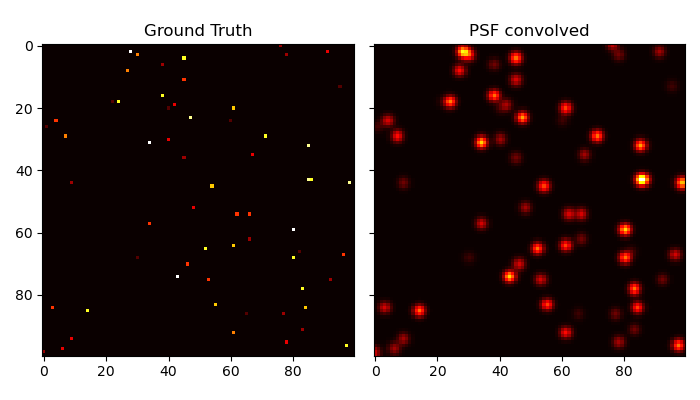

In [76]:
#plt.figure()
fig,axs = plt.subplots(1,2, figsize=(7,4), sharex=True, sharey=True)
axs[0].imshow(img, cmap='hot')
axs[0].set_title('Ground Truth')
axs[1].imshow(convolved_img, cmap='hot')
axs[1].set_title('PSF convolved')

plt.tight_layout()
#plt.savefig("../figures/ground_truth_vs_simulated_img.jpg", dpi=750)

## Adaptive max_value or q_quantile based thresholding

In [68]:
output_image = adaptive_q_perc_thresholding(convolved_img)
contours = get_contours_in_image(output_image, thr_level=1)
no_of_peaks_retrieved = len(contours)
print("No_of_peaks_retrieved:", no_of_peaks_retrieved)

No_of_peaks_retrieved: 54


## Retrieve peak locations

In [69]:
true_peak_positions = list(zip(df["row"], df["col"]))
total_true_peaks = len(true_peak_positions)
total_true_peaks

62

In [70]:
# Find the coordinates of the maxima inside the contour
retrieved_peaks_xy = []
for contour in contours:
    max_point_index = get_coo_of_maxima_inside_contour(convolved_img, contour)
    retrieved_peaks_xy.append(max_point_index)
total_detected_peaks = len(retrieved_peaks_xy)
total_detected_peaks

54

## Visualize an example image

<IPython.core.display.Javascript object>


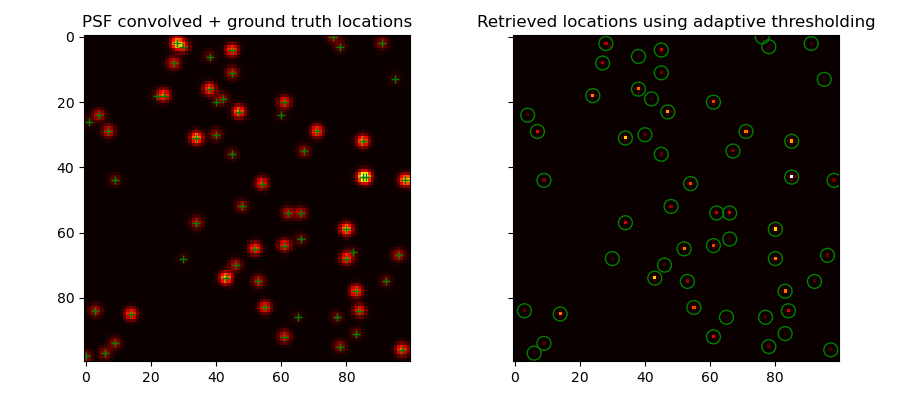

In [77]:
# visualize simulated image and retieved peak locations
fig,axs = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
axs[0].imshow(convolved_img, cmap='hot')
for j,i in zip(df["row"], df["col"]):
    axs[0].plot(i,j, "g+")
axs[0].set_title('PSF convolved + ground truth locations')

axs[1].imshow(output_image, cmap='hot')
for p in retrieved_peaks_xy:
    axs[1].scatter(p[1],p[0], s=100, edgecolors='g', facecolors='none')
    #axs[1].plot(p[1],p[0], color='g', marker='o', linewidth=0.5)
axs[1].set_title('Retrieved locations using adaptive thresholding')

plt.tight_layout()
#plt.savefig("../figures/simulated_img_vs_peak_localizations.jpg", dpi=750)

## Statistics / Confusion matrix

In [72]:
# Find pairs in retrieved_peaks_xy that are within 1-pixel distance from each pair in true_peak_positions
matched_idxs_within_1_pixel_distance = []
true_peak_positions_copy = deepcopy(true_peak_positions)
for i, j in retrieved_peaks_xy:
    if true_peak_positions_copy:
        for k,l in true_peak_positions_copy:
            distance = euclidean((i, j), (k,l))
            if distance < 1:
                matched_idxs_within_1_pixel_distance.append((i, j))
                true_peak_positions_copy.remove((k,l))
correctly_detected_peaks = len(matched_idxs_within_1_pixel_distance)
print("Matched indices within 1-pixel distance:", correctly_detected_peaks)


Matched indices within 1-pixel distance: 54


In [73]:
# Calculate TP, FP, TN, FN
TP = correctly_detected_peaks
FP = total_detected_peaks - correctly_detected_peaks
TN = total_true_peaks - correctly_detected_peaks
FN = total_true_peaks - TP

# Print as Markdown table
print("|      | Peaks | Non-Peaks |")
print("|------|-------|----------|")
print("| True |  {}   |    {}    |".format(TP, FN))
print("| False |  {}   |    {}    |".format(FP, TN))

|      | Peaks | Non-Peaks |
|------|-------|----------|
| True |  54   |    8    |
| False |  0   |    8    |


In [74]:
# Calculate accuracy and specificity
accuracy = (TP + TN) / (TP + FP + TN + FN)
specificity = TN / (TN + FP)

# Print the results
print("Accuracy: {:.2f}".format(accuracy))
print("Specificity: {:.2f}".format(specificity))

Accuracy: 0.89
Specificity: 1.00


# Run above example over several simulated images

In [56]:
n_images_to_simulate = 100

In [57]:
no_of_true_peaks_list = []
no_of_detected_peaks_list = []
no_of_corrected_detected_peaks_list = []

accuracy_list = []
specificity_list = []

for c in tqdm(np.arange(n_images_to_simulate)):
    #======= 1. SIMULATE IMAGE =======
    df, img = simulate_image()
    true_peak_positions = list(zip(df["row"], df["col"]))
    total_true_peaks = len(true_peak_positions)
    no_of_true_peaks_list.append(total_true_peaks)
    #
    #======= 2. APPLY PSF =======
    convolved_img = apply_psf(img, sigma=1.3)
    #
    #======= 3. RETRIEVAL PROCESS =======
    #======== 3.1 ADAPTIVE THRESHOLDING ======
    output_image = adaptive_q_perc_thresholding(convolved_img)
    #
    #======== 3.1 IDENTIFY LOCATIONS OF PEAKS ======
    contours = get_contours_in_image(output_image, thr_level=1)
    # Find the coordinates of the maxima inside the contour
    retrieved_peaks_xy = []
    for contour in contours:
        max_point_index = get_coo_of_maxima_inside_contour(convolved_img, contour)
        retrieved_peaks_xy.append(max_point_index)
    total_detected_peaks = len(retrieved_peaks_xy)
    no_of_detected_peaks_list.append(total_detected_peaks)
    #
    #======== 3.2 FIND CORRECTLY IDENTIFIED PEAKS =====
    # Find pairs in retrieved_peaks_xy that are within 1-pixel distance from each pair in true_peak_positions
    matched_idxs_within_1_pixel_distance = []
    true_peak_positions_copy = deepcopy(true_peak_positions)
    for i, j in retrieved_peaks_xy:
        if true_peak_positions_copy:
            for k,l in true_peak_positions_copy:
                distance = euclidean((i, j), (k,l))
                if distance < 1:
                    matched_idxs_within_1_pixel_distance.append((i, j))
                    true_peak_positions_copy.remove((k,l))
    correctly_detected_peaks = len(matched_idxs_within_1_pixel_distance)
    no_of_corrected_detected_peaks_list.append(correctly_detected_peaks)
    #
    #======== 3.3 CALCULATE CONFUSION MATRIX ======
    # Calculate TP, FP, TN, FN
    TP = correctly_detected_peaks
    FP = total_detected_peaks - correctly_detected_peaks
    TN = total_true_peaks - correctly_detected_peaks
    FN = total_true_peaks - TP
    #
    # Calculate accuracy and specificity
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else np.nan
    #
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)

  0%|          | 0/100 [00:00<?, ?it/s]

## Retrieval Performance

<IPython.core.display.Javascript object>


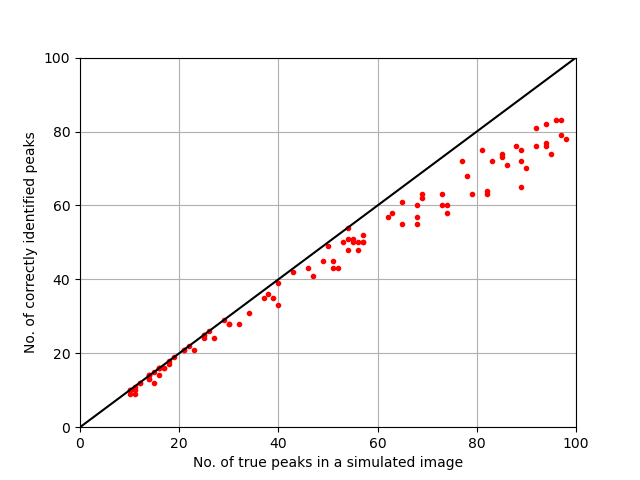

In [78]:
# Plot the data points and the fitted line
plt.figure()
#plt.axhline(1.0, color='k')
plt.plot(no_of_true_peaks_list, no_of_corrected_detected_peaks_list, 'r.')
plt.plot([0,100],[0,100],'k-')
plt.axis((0,100,0,100))
plt.grid(True)
#plt.plot(no_of_corrected_detected_peaks_list, '')
plt.xlabel('No. of true peaks in a simulated image')
plt.ylabel('No. of correctly identified peaks')
#plt.savefig("../figures/no_of_true_peaks_vs_correctly_idenfitied_over_100_simulated_images.jpg", dpi=750)

## Accuracy is decreasing as more true peaks are present in an image 

R_value: -6.45e-01


<IPython.core.display.Javascript object>


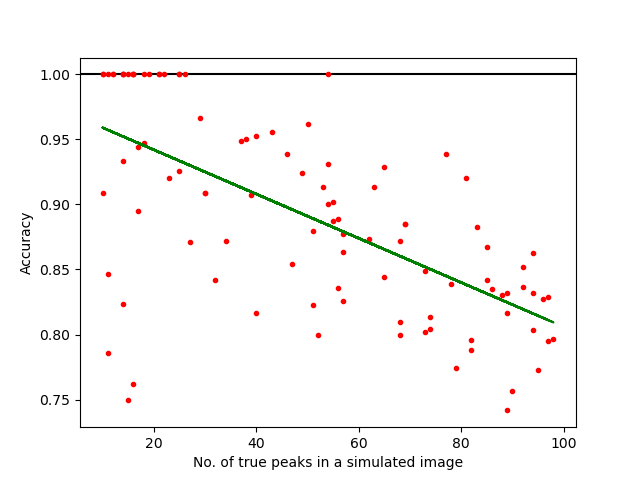

In [79]:
# Perform linear regression to get line parameters (slope, intercept, r-value, p-value, and std_err)
slope, intercept, r_value, p_value, std_err = linregress(no_of_true_peaks_list, accuracy_list)

# Calculate the fitted line
fitted_line = slope * np.array(no_of_true_peaks_list) + intercept

print("R_value:", np.round(r_value,3))

# Plot the data points and the fitted line
plt.figure()
plt.axhline(1.0, color='k')
plt.plot(no_of_true_peaks_list, accuracy_list, 'r.')

plt.plot(no_of_true_peaks_list, fitted_line, color='g', label='Fitted Line')
plt.xlabel('No. of true peaks in a simulated image')
plt.ylabel('Accuracy')
#plt.savefig("../figures/accuracy_from_100_simulated_images.jpg", dpi=750)

## TODO: add noise